In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
from scipy.stats.stats import pearsonr

In [2]:
#Import Hass Avocado Board data. Merge files from different years.

kag_df = pd.read_csv("data/avo-volume-and-price-data.csv")

def create_df(fname, year_start, year_end):
    dfs = []
    for y in range(year_start, year_end+1):
        dfs.append(pd.read_csv(f"data/{y}-{fname}.csv"))
    return pd.concat(dfs)

per_df = create_df('market-region-hab-data',2017,2020)
wkly_rtl_df = create_df('plu-total-hab-data',2017,2020)
vol_df = create_df('volume',2017,2020)

In [3]:
per_df['Current Year Week Ending']

0      2017-01-29 00:00:00
1      2017-02-26 00:00:00
2      2017-03-26 00:00:00
3      2017-04-23 00:00:00
4      2017-05-21 00:00:00
              ...         
103    2020-02-23 00:00:00
104    2020-02-23 00:00:00
105    2020-02-23 00:00:00
106    2020-02-23 00:00:00
107    2020-02-23 00:00:00
Name: Current Year Week Ending, Length: 2268, dtype: object

In [4]:
kag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
Unnamed: 0      18249 non-null int64
Date            18249 non-null object
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
4046            18249 non-null float64
4225            18249 non-null float64
4770            18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [5]:
wkly_rtl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17388 entries, 0 to 863
Data columns (total 13 columns):
Geography                    17388 non-null object
Timeframe                    17388 non-null object
Current Year Week Ending     17388 non-null object
Type                         17388 non-null object
ASP Current Year             17388 non-null float64
Total Bulk and Bags Units    17388 non-null float64
4046 Units                   17388 non-null float64
4225 Units                   17388 non-null float64
4770 Units                   17388 non-null float64
TotalBagged Units            17388 non-null float64
SmlBagged Units              17388 non-null float64
LrgBagged Units              17388 non-null float64
X-LrgBagged Units            17388 non-null float64
dtypes: float64(9), object(4)
memory usage: 1.9+ MB


In [6]:
wkly_rtl_df['Current Year Week Ending'] = pd.to_datetime(wkly_rtl_df['Current Year Week Ending'])

In [7]:
print(vol_df.columns)

Index(['Week', 'Status', 'Total Volume', 'California', 'Chile', 'Mexico',
       'Peru', 'Colombia'],
      dtype='object')


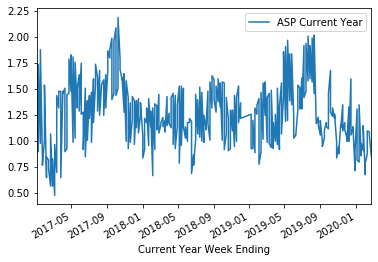

In [8]:
#Check if ambiguously named 'ASP Current Year' column looks like a YTD average. The value does not converge over the course of each year, so the answer is no.

wkly_rtl_df.loc[wkly_rtl_df['Geography']=='Detroit',['Current Year Week Ending', 'ASP Current Year']].plot('Current Year Week Ending')

In [64]:
kag_df['Date'] = pd.to_datetime(kag_df['Date'])
kag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
Unnamed: 0      18249 non-null int64
Date            18249 non-null datetime64[ns]
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
4046            18249 non-null float64
4225            18249 non-null float64
4770            18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 1.9+ MB


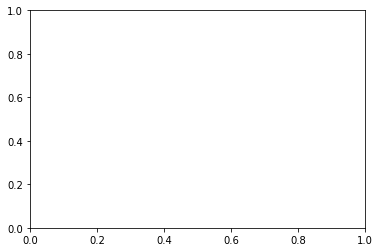

In [65]:
fig, ax = plt.subplots()

In [12]:
kag_df.groupby("type").groups

{'conventional': Int64Index([1819, 2807, 1195,  103, 1143,  623, 1871, 2547, 2131,  259,
             ...
             8994, 8502, 8586, 8730, 8862, 8526, 8850, 8574, 9018, 8814],
            dtype='int64', length=9126),
 'organic': Int64Index([11569,  9593, 10009,  9333, 10269, 10425, 11673, 10945, 11725,
             10477,
             ...
             18045, 17829, 17661, 17925, 18153, 17841, 18057, 17649, 18141,
             17673],
            dtype='int64', length=9123)}

In [15]:
#Rename columns. PLU numbers correspond to size. Kaggle data mislabeled bagged avocados as bags of avocados.

kag_df.rename(
    columns={"AveragePrice":'ASP', '4046':'Small', '4225':'Large','4770':'Jumbo',
             'region':'Region', 'type':'Type', 'Total Volume':'Total Units',
             'XLarge Bags':'Jumbo Bagged', 'Total Bags':'Total Bagged', 
             'Small Bags':'Small Bagged'},
    inplace=True)

wkly_rtl_df.rename(
    columns={'Geography':'Region', 'Current Year Week Ending':'Date', 
             'ASP Current Year':'ASP', 'Total Bulk and Bags Units':'Total Units',
             '4046 Units':'Small', '4225 Units':'Large', '4770 Units':'Jumbo',
             'TotalBagged Units':'Total Bagged', 'SmlBagged Units':'Small Bagged', 
             'LrgBagged Units':'Large Bags', 'X-LrgBagged Units':'Jumbo Bagged'},
    inplace=True)

vol_df.rename(
    columns={'Week':'Date'},
    inplace=True)
                   

In [18]:
def create_datecols(df):
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Weekday'] = df.apply(lambda row: row['Date'].weekday(), axis=1)
    df['Month'] = df.apply(lambda row: row['Date'].month, axis=1)
    df['Day'] = df.apply(lambda row: row['Date'].day, axis=1)
    # df['Timestamp'] = df.apply(lambda row: row['Date'].timestamp(), axis=1)
    df['Year'] = df.apply(lambda row: row['Date'].year, axis=1)
    
    return df.sort_values(by=['Date'])

kag_df = create_datecols(kag_df)
wkly_rtl_df = create_datecols(wkly_rtl_df)
vol_df = create_datecols(vol_df)